In [ ]:
!pip install yfinance
!pip install ta
!pip install wikipedia


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=b85dc8281964198aa128af049957014e39c64a9ca787531c4f40c5bfe71cb3ad
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=1b1810345fd2567bc933c8e0a6630ff3fe397012daacf6391a719e8299e8308a
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import wikipedia as wp
import yfinance as yf
from ta.momentum import rsi
from ta.trend import macd

In [ ]:
page  = wp.page("S&P 100").html().encode("UTF-8")
stocks = pd.read_html(page)[2].set_index("Symbol")
stocks = stocks.drop("GOOG")
stocks.loc["GOOGL", "Name"] = "Alphabet"
stocks = stocks.rename(index={"BRK.B": "BRK-B"})
stocks.head(100)

,Name,Sector
Symbol,,
AAPL,Apple Inc.,Information Technology
ABBV,AbbVie,Health Care
ABT,Abbott Laboratories,Health Care
ACN,Accenture,Information Technology
ADBE,Adobe Inc.,Information Technology
...,...,...
V,Visa Inc.,Financials
VZ,Verizon,Communication Services
WFC,Wells Fargo,Financials


In [ ]:
stocks.to_csv("/content/drive/MyDrive/Financial GNN/data/stocks.csv")


##Fundamendal Data

In [ ]:

fundamentals = [
	yf.Ticker(stock).info for stock in stocks.index
]
fundamentals = pd.DataFrame(fundamentals).set_index("symbol")
fundamentals.index = fundamentals.index.rename("Symbol")  # for consistency with the stocks dataframe


In [ ]:
#TODO: Fix "pegRatio"
fundamentals = fundamentals[["marketCap", "trailingPE", "forwardPE", "priceToBook", "trailingEps", "forwardEps", "bookValue", "payoutRatio", "beta", "fiveYearAvgDividendYield", "52WeekChange", "averageVolume", "enterpriseToRevenue", "profitMargins"]].fillna(0)
fundamentals.head()

,marketCap,trailingPE,forwardPE,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,
AAPL,3189540126720,33.211510,25.697954,47.763363,6.43,8.31,4.471,0.1558,1.211,0.55,-0.056508,62010880,7.778,0.24301
ABBV,334344192000,80.544685,15.604286,235.422880,2.35,12.13,0.804,2.6880,0.491,3.91,0.131719,7500001,6.847,0.07313
ABT,233904095232,17.459742,26.054264,4.792016,7.70,5.16,28.055,0.2909,0.737,1.67,0.292444,6669462,5.747,0.31886
ACN,189833134080,24.265923,21.661692,6.211760,12.56,14.07,49.065,0.4558,1.327,1.39,0.018854,3328560,2.711,0.11607
ADBE,160903299072,24.268074,18.457909,14.148079,15.63,20.55,26.810,0.0000,1.545,0.12,-0.344140,3837467,7.300,0.30392


In [ ]:
#normalise financials

normalised = (fundamentals - fundamentals.mean()/fundamentals.std())
normalised.head()

,marketCap,trailingPE,forwardPE,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,
AAPL,3.189540e+12,32.620933,25.128354,47.435531,5.828536,7.70869,4.370089,-0.995478,-0.972816,-0.773713,-0.521214,6.201088e+07,7.187774,-1.110158
ABBV,3.343442e+11,79.954108,15.034686,235.095048,1.748536,11.52869,0.703089,1.536722,-1.692816,2.586287,-0.332987,7.500000e+06,6.256774,-1.280038
ABT,2.339041e+11,16.869165,25.484664,4.464184,7.098536,4.55869,27.954089,-0.860378,-1.446816,0.346287,-0.172262,6.669461e+06,5.156774,-1.034308
ACN,1.898331e+11,23.675346,21.092092,5.883928,11.958536,13.46869,48.964089,-0.695478,-0.856816,0.066287,-0.445852,3.328559e+06,2.120774,-1.237098
ADBE,1.609033e+11,23.677497,17.888309,13.820247,15.028536,19.94869,26.709089,-1.151278,-0.638816,-1.203713,-0.808846,3.837466e+06,6.709774,-1.049248


In [ ]:
#export csv
normalised.to_csv("/content/drive/MyDrive/Financial GNN/data/fundamentals.csv")

#Historical Market Data

In [ ]:

values = [
	yf.Ticker(stock).history(period="5y", actions=False) for stock in stocks.index
]


In [ ]:
for idx, stock_vals in enumerate(values):
	#normalise close
  stock_vals["Close"] = stock_vals["Close"] / stock_vals["Close"][0]
  #log returns
  stock_vals["DailyLogReturn"] = np.log(1 + stock_vals["Close"].pct_change())
  stock_vals["1W_LR"] = stock_vals["DailyLogReturn"].rolling(window=5).sum() * 5
  stock_vals["2W_LR"] = stock_vals["DailyLogReturn"].rolling(window=10).sum() * 10
  stock_vals["1M_LR"] = stock_vals["DailyLogReturn"].rolling(window=21).sum() * 21
  stock_vals["3M_LR"] = stock_vals["DailyLogReturn"].rolling(window=63).sum() * 63
  #Normalise std
  stock_vals["DailyLogReturn"] /= stock_vals["DailyLogReturn"].std()
  stock_vals["1W_LR"] /= stock_vals["1W_LR"].std()
  stock_vals["2W_LR"] /= stock_vals["2W_LR"].std()
  stock_vals["1M_LR"] /= stock_vals["1M_LR"].std()
  stock_vals["3M_LR"] /= stock_vals["3M_LR"].std()
  stock_vals["RSI"] = rsi(stock_vals["Close"], window=14)/ 100
  stock_vals["MACD"] = macd(stock_vals["Close"])
  stock_vals.drop(columns=["Open", "High", "Low", "Volume"], inplace=True)





/tmp/ipython-input-10-952140201.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stock_vals["Close"] = stock_vals["Close"] / stock_vals["Close"][0]
/tmp/ipython-input-10-952140201.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stock_vals["Close"] = stock_vals["Close"] / stock_vals["Close"][0]
/tmp/ipython-input-10-952140201.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stock_vals["Close"] = stock_vals["Close"] / stock_

In [ ]:
values = pd.concat(values, keys=stocks.index).dropna()
values.head()

Close  DailyLogReturn     1W_LR  \
Symbol Date                                                            
AAPL   2020-10-02 00:00:00-04:00  1.211435       -1.750557  0.160465   
       2020-10-05 00:00:00-04:00  1.248737        1.617919  0.325065   
       2020-10-06 00:00:00-04:00  1.212936       -1.551866 -0.199938   
       2020-10-07 00:00:00-04:00  1.233516        0.897585 -0.154469   
       2020-10-08 00:00:00-04:00  1.232337       -0.050999 -0.383669   

                                     2W_LR     1M_LR     3M_LR       RSI  \
Symbol Date                                                                
AAPL   2020-10-02 00:00:00-04:00  1.005550 -1.923406  1.636347  0.485839   
       2020-10-05 00:00:00-04:00  1.013625 -0.471106  1.921585  0.533342   
       2020-10-06 00:00:00-04:00  0.214616 -0.850860  1.477008  0.486851   
       2020-10-07 00:00:00-04:00  1.281746  0.253173  1.583934  0.513124   
       2020-10-08 00:00:00-04:00  1.081958 -0.258279  1.560870  0.511509   

                                      MACD  
Symbol Date                                 
AAPL   2020-10-02 00:00:00-04:00 -0.004295  
       2020-10-05 00:00:00-04:00 -0.001512  
       2020-10-06 00:00:00-04:00 -0.002171  
       2020-10-07 00:00:00-04:00 -0.001020  
       2020-10-08 00:00:00-04:00 -0.000201

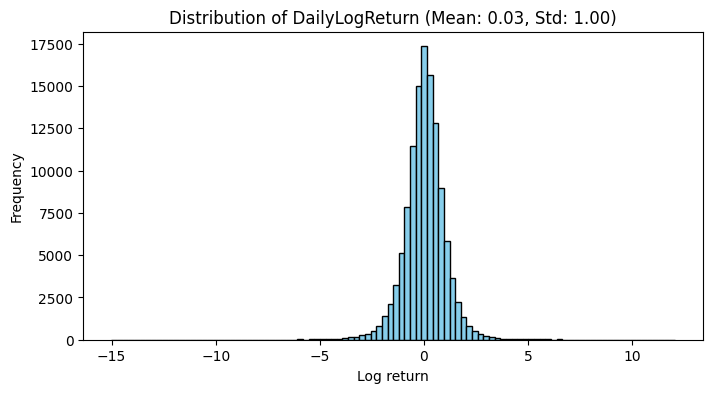

In [ ]:
plt.figure(figsize=(8, 4))

column = "DailyLogReturn"
plt.hist(values[column], bins=100, color="skyblue", edgecolor="black")
plt.title(f"Distribution of {column} (Mean: {values[column].mean():.2f}, Std: {values[column].std():.2f})")
plt.xlabel("Log return")
plt.ylabel("Frequency")
plt.show()

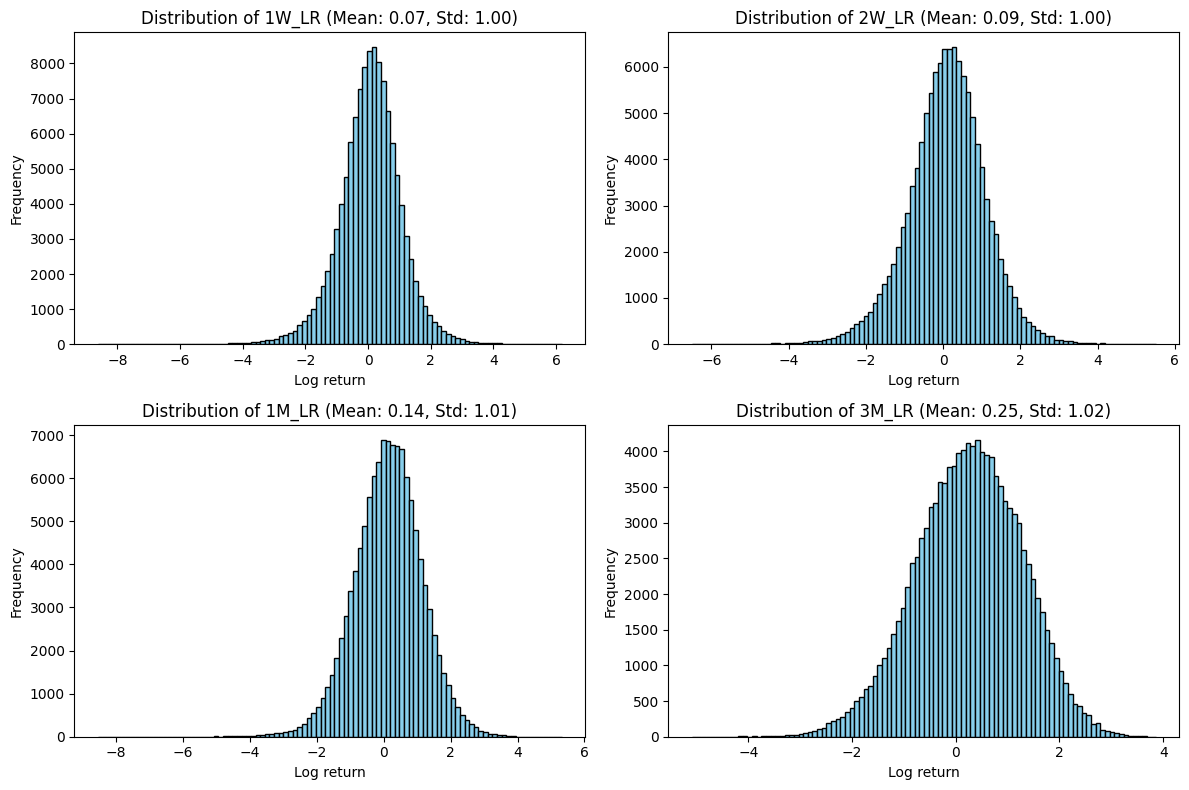

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for idx, column in enumerate(["1W_LR", "2W_LR", "1M_LR", "3M_LR"]):
	ax = axs[idx // 2, idx % 2]
	ax.hist(values[column], bins=100, color="skyblue", edgecolor="black")
	ax.set_title(f"Distribution of {column} (Mean: {values[column].mean():.2f}, Std: {values[column].std():.2f})")
	ax.set_xlabel("Log return")
	ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


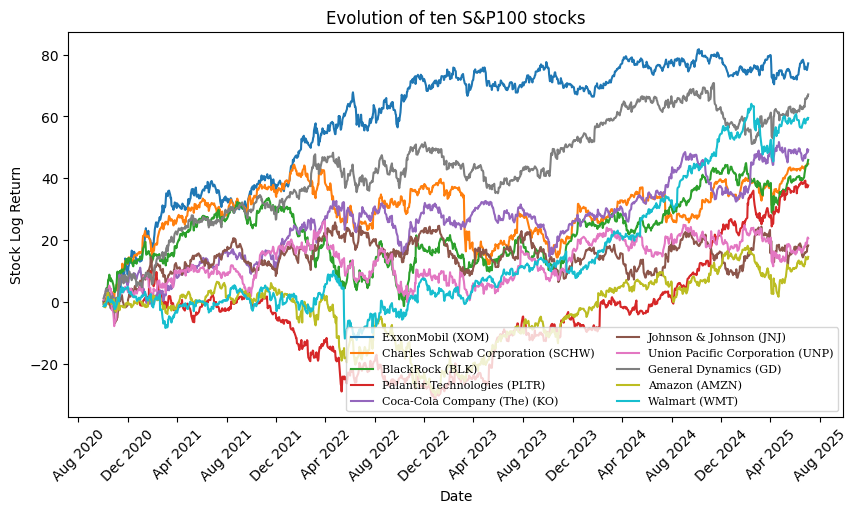

In [ ]:
plt.figure(figsize=(10, 5))

for stock in np.random.choice(stocks.index, size=10, replace=False):
	plt.plot(values.loc[stock].index, np.cumsum(values.loc[stock]["DailyLogReturn"]), label=f'{stocks.loc[stock]["Name"]} ({stock})')
plt.title(f"Evolution of ten S&P100 stocks")
plt.xlabel('Date')
plt.gca().tick_params(axis='x', rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.ylabel('Stock Log Return')
plt.legend(ncol=2, loc="lower right", prop={'size': 8, 'family': 'serif'})
plt.show()

In [ ]:
values.to_csv("/content/drive/MyDrive/Financial GNN/data/stock_history.csv")

#Graph Creation


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

In [ ]:
!pip install adjustText

**Exploratory Visualisation**

/tmp/ipython-input-19-787498180.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20c', len(sectors))


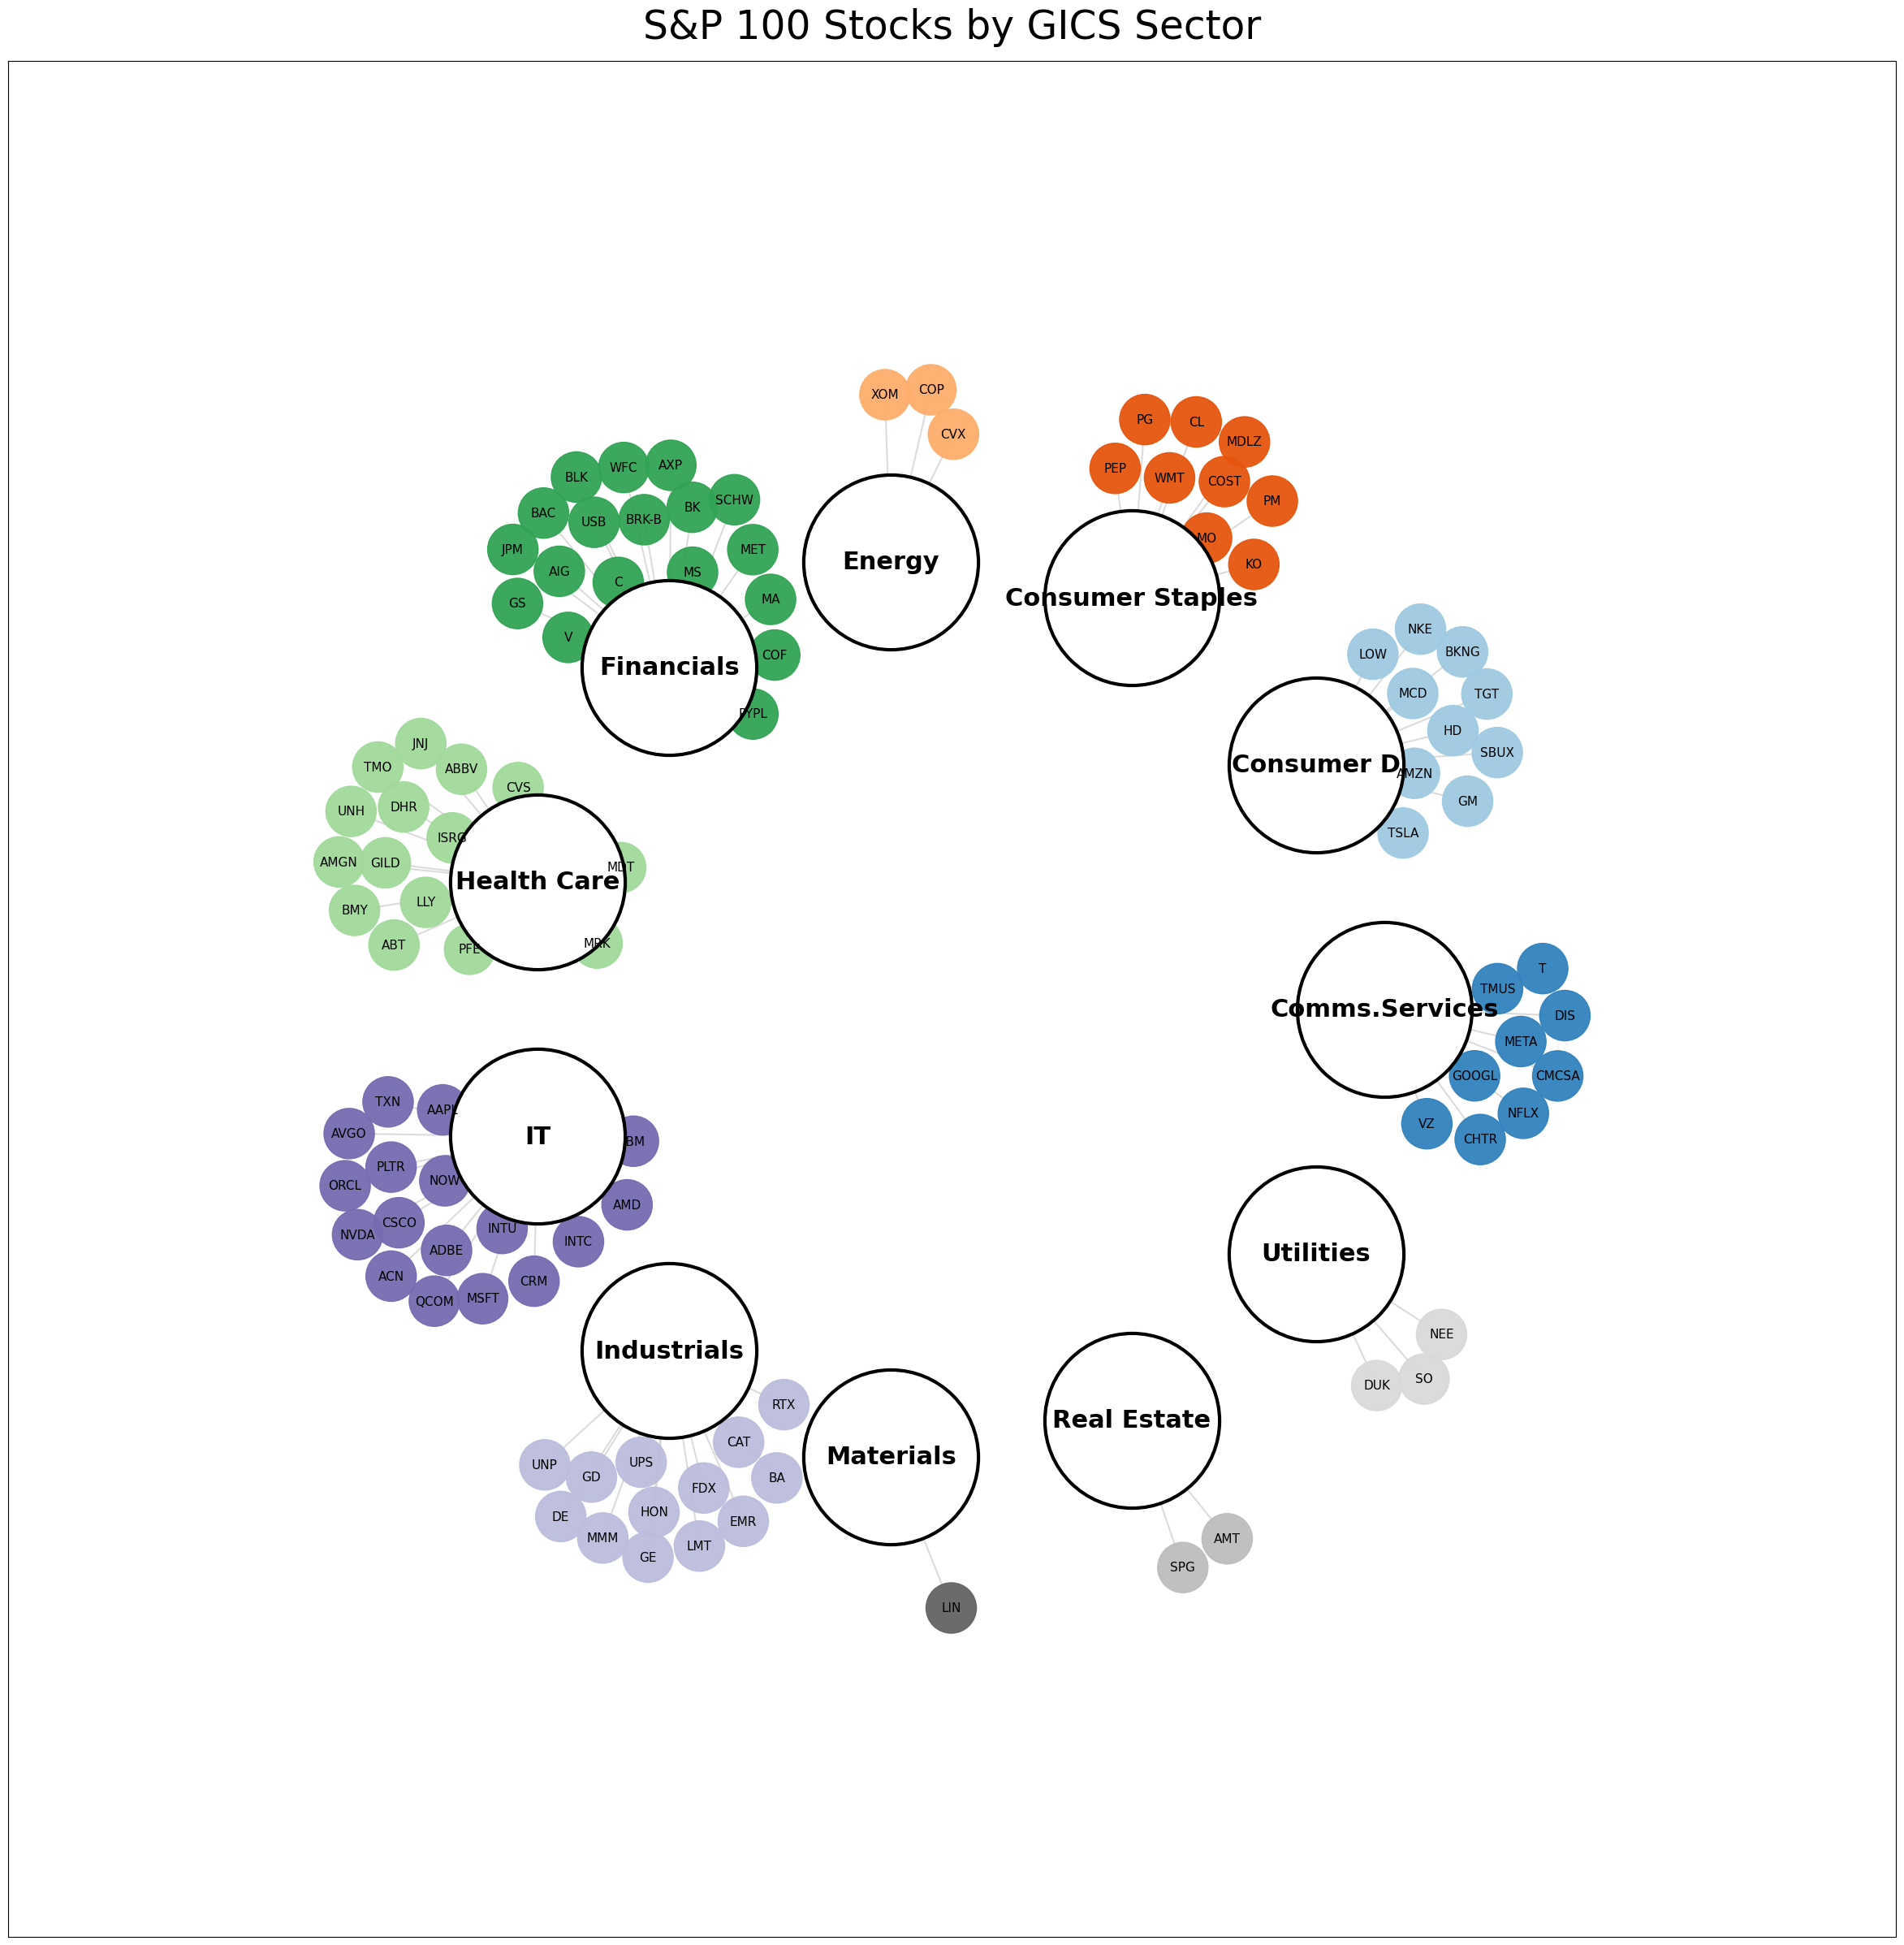

In [ ]:
# --- Graph Creation and Pre-processing ---
G_hub = nx.Graph()

stocks['Sector'] = stocks['Sector'].replace({
    'Information Technology': 'IT',
    'Communication Services': 'Comms.Services',
    'Consumer Discretionary': 'Consumer D'
})
sectors = sorted(stocks['Sector'].unique())

# Build the graph nodes
for sector in sectors:
    G_hub.add_node(sector, type='sector')
for index, row in stocks.iterrows():
    G_hub.add_node(index, type='stock', sector=row['Sector'])

# --- ** CRITICAL CHANGE 1: ADD WEIGHTED EDGES ** ---
# Add edges with a low weight to create a longer "spring" between hubs and stocks.
for index, row in stocks.iterrows():
    stock_node, sector_node = index, row['Sector']
    # A smaller weight results in a larger resting distance in the spring layout.
    G_hub.add_edge(stock_node, sector_node, weight=0.1)

# --- Coloring ---
colors = plt.cm.get_cmap('tab20c', len(sectors))
sector_colors = {sector: colors(i) for i, sector in enumerate(sectors)}

# =========================================================================
# ===            FINAL LAYOUT AND DRAWING WITH SPACING                  ===
# =========================================================================

# --- Stage 1: Position Sector Hubs in a Circle ---
pos_hubs = {}
sector_nodes = [node for node, data in G_hub.nodes(data=True) if data['type'] == 'sector']
num_sectors = len(sector_nodes)
angles = np.linspace(0, 2 * np.pi, num_sectors, endpoint=False)
# ** CRITICAL CHANGE 2: Increase the main radius to prevent larger clusters from overlapping **
radius = 8.0
for i, node in enumerate(sector_nodes):
    pos_hubs[node] = (radius * np.cos(angles[i]), radius * np.sin(angles[i]))

# --- Stage 2: Position Stocks Around Their Fixed Hubs ---
pos = nx.spring_layout(G_hub,
                       pos=pos_hubs,
                       fixed=sector_nodes,
                       # ** CRITICAL CHANGE 3: Tell the layout to use our edge weights **
                       weight='weight',
                       k=0.5, # Controls spacing between stocks within a cluster
                       iterations=100,
                       seed=42)

# --- Drawing the Graph ---
fig, ax = plt.subplots(figsize=(30, 30))

# Draw edges
nx.draw_networkx_edges(G_hub, pos, ax=ax, edge_color='lightgray', width=1.5, alpha=0.8)

# Draw stock nodes
stock_nodes = [node for node, data in G_hub.nodes(data=True) if data['type'] == 'stock']
stock_colors = [sector_colors[G_hub.nodes[node]['sector']] for node in stock_nodes]
nx.draw_networkx_nodes(G_hub, pos, ax=ax,
                       nodelist=stock_nodes,
                       node_color=stock_colors,
                       node_size=2000,
                       alpha=0.95)

# Draw sector hubs
nx.draw_networkx_nodes(G_hub, pos, ax=ax,
                       nodelist=sector_nodes,
                       node_color='white',
                       edgecolors='black',
                       linewidths=3,
                       node_size=24000)

# --- Polished Labeling ---
# Draw Sector labels directly and lock them in place.
sector_labels = {node: node for node in sector_nodes}
nx.draw_networkx_labels(G_hub, pos, ax=ax,
                        labels=sector_labels,
                        font_size=22,
                        font_weight='bold')

# Prepare stock labels for adjustment
stock_texts = []
for node in stock_nodes:
    x, y = pos[node]
    stock_texts.append(ax.text(x, y, node, fontsize=11, ha='center', va='center'))

# Use adjust_text ONLY on stock labels.
'''adjust_text(stock_texts,
            ax=ax,
            expand_points=(1.8, 1.8),
            force_text=(0.5, 0.8),
            force_points=(0.5, 0.8),
            arrowprops=None)'''

ax.set_title("S&P 100 Stocks by GICS Sector", fontsize=35, pad=20)
ax.margins(0.2) # Increase margin even more to accommodate the larger layout

# --- Save the High-Quality Figure ---
plt.savefig("stock_network_final.png", dpi=300, bbox_inches='tight')
plt.show()

**GRAPH CONSTRUCTION**

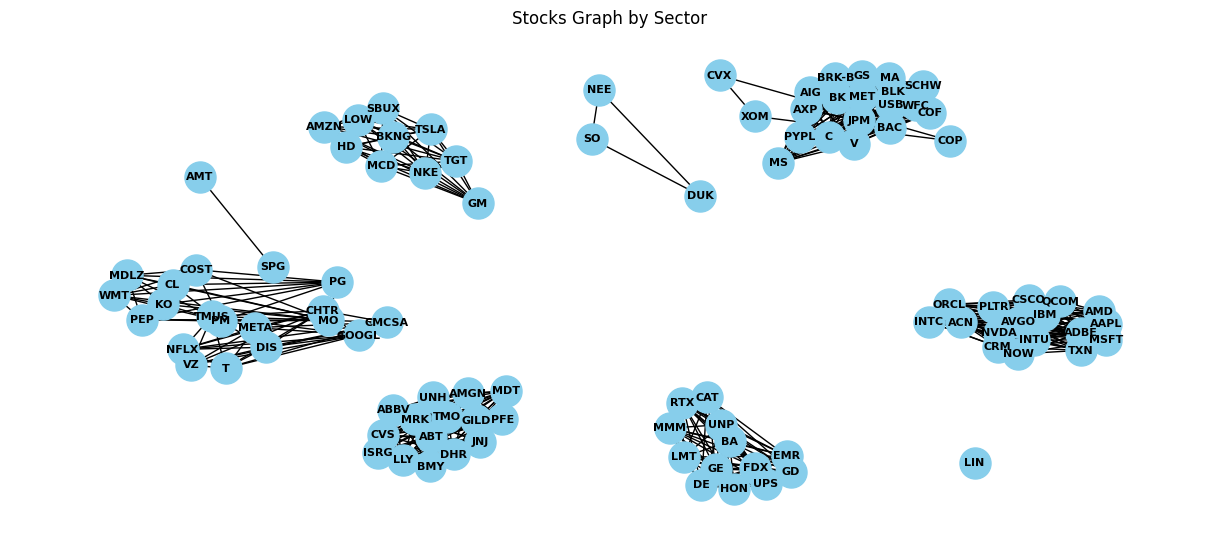

In [ ]:
adj_stocks = np.array([
    [int((stocks.loc[stock1, 'Sector'] == stocks.loc[stock2, 'Sector']) and (stock1 != stock2))
     for stock1 in stocks.index]
    for stock2 in stocks.index
])

stocks_graph = nx.from_numpy_array(adj_stocks)
stocks_graph = nx.relabel_nodes(stocks_graph, dict(enumerate(stocks.index)))

plt.figure(figsize=(12, 5))
nx.draw(stocks_graph, with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', font_color='black', pos=nx.spring_layout(stocks_graph, k=.5))
plt.title('Stocks Graph by Sector')
plt.show()

##Graphy by fundamentals


Using fundamental data such as Marketcap and P/e ratio etc. We link stocks based on their cluster and correlation

In [ ]:
fundamenals = pd.read_csv("/content/drive/MyDrive/Financial GNN/data/fundamentals.csv").set_index("Symbol")
fundamenals.head()

,marketCap,trailingPE,forwardPE,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,
AAPL,3.189540e+12,32.620933,25.128354,47.435531,5.828536,7.70869,4.370089,-0.995478,-0.972816,-0.773713,-0.521214,6.201088e+07,7.187774,-1.110158
ABBV,3.343442e+11,79.954108,15.034686,235.095048,1.748536,11.52869,0.703089,1.536722,-1.692816,2.586287,-0.332987,7.500000e+06,6.256774,-1.280038
ABT,2.339041e+11,16.869165,25.484664,4.464184,7.098536,4.55869,27.954089,-0.860378,-1.446816,0.346287,-0.172262,6.669461e+06,5.156774,-1.034308
ACN,1.898331e+11,23.675346,21.092092,5.883928,11.958536,13.46869,48.964089,-0.695478,-0.856816,0.066287,-0.445852,3.328559e+06,2.120774,-1.237098
ADBE,1.609033e+11,23.677497,17.888309,13.820247,15.028536,19.94869,26.709089,-1.151278,-0.638816,-1.203713,-0.808846,3.837466e+06,6.709774,-1.049248


In [ ]:
fundamentals_corr = fundamentals.transpose().corr(method="spearman")
fundamentals_corr = (fundamentals_corr - (fundamentals_corr == 1))  # Remove self-correlation
fundamentals_corr.head(n=10)

Symbol,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,0.000000,0.907692,0.810989,0.846154,0.846154,0.767033,0.864687,0.951648,0.942857,0.895490,...,0.890110,0.784615,0.846154,0.815385,0.767033,0.925275,0.727473,0.767033,0.890110,0.780220
ABBV,0.907692,0.000000,0.657143,0.740659,0.670330,0.701099,0.717272,0.916484,0.916484,0.739274,...,0.846154,0.674725,0.740659,0.714286,0.718681,0.793407,0.709890,0.665934,0.824176,0.727473
ABT,0.810989,0.657143,0.000000,0.960440,0.938462,0.947253,0.913092,0.828571,0.872527,0.904291,...,0.925275,0.903297,0.960440,0.929670,0.929670,0.938462,0.912088,0.978022,0.916484,0.929670
ACN,0.846154,0.740659,0.960440,0.000000,0.973626,0.978022,0.921893,0.916484,0.898901,0.917492,...,0.942857,0.960440,0.000000,0.986813,0.960440,0.934066,0.947253,0.964835,0.956044,0.982418
ADBE,0.846154,0.670330,0.938462,0.973626,0.000000,0.925275,0.941695,0.890110,0.850549,0.932894,...,0.894505,0.942857,0.973626,0.956044,0.907692,0.925275,0.872527,0.916484,0.907692,0.929670
AIG,0.767033,0.701099,0.947253,0.978022,0.925275,0.000000,0.869087,0.859341,0.850549,0.855886,...,0.912088,0.947253,0.978022,0.973626,0.982418,0.885714,0.978022,0.982418,0.938462,0.986813
AMD,0.864687,0.717272,0.913092,0.921893,0.941695,0.869087,0.000000,0.858086,0.906491,0.929515,...,0.941695,0.814082,0.921893,0.880089,0.888889,0.963697,0.831684,0.869087,0.877888,0.858086
AMGN,0.951648,0.916484,0.828571,0.916484,0.890110,0.859341,0.858086,0.000000,0.947253,0.893290,...,0.920879,0.876923,0.916484,0.898901,0.850549,0.907692,0.837363,0.824176,0.938462,0.890110
AMT,0.942857,0.916484,0.872527,0.898901,0.850549,0.850549,0.906491,0.947253,0.000000,0.893290,...,0.982418,0.793407,0.898901,0.854945,0.863736,0.951648,0.846154,0.846154,0.925275,0.863736


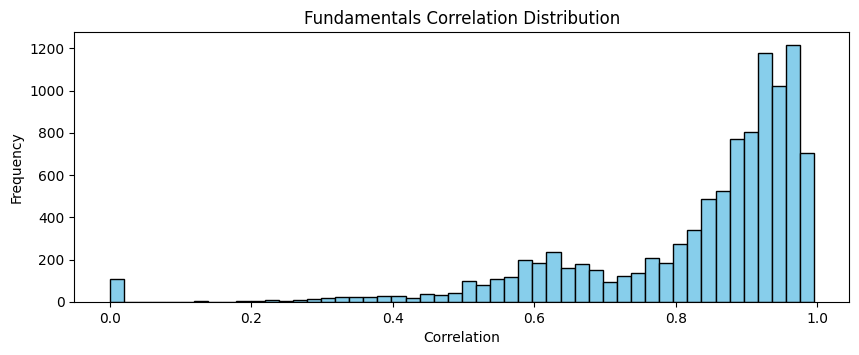

In [ ]:

plt.figure(figsize=(10, 3.5))
plt.hist(fundamentals_corr.values.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title('Fundamentals Correlation Distribution')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.show()

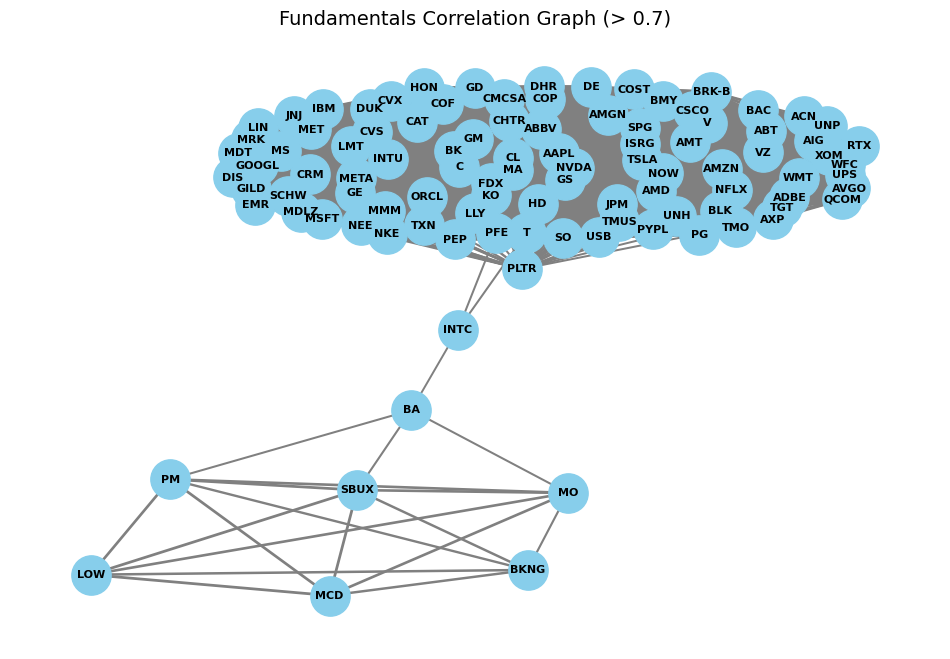

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Convert to numpy and threshold
fundamentals_corr_np = fundamentals_corr.to_numpy()

#Adencency matrix [IMPORTANT]
adj_fundamentals_corr = fundamentals_corr_np * (abs(fundamentals_corr_np) > 0.7).astype(int)

# Remove self-loops
np.fill_diagonal(adj_fundamentals_corr, 0)

# Create graph
G = nx.from_numpy_array(adj_fundamentals_corr)
G = nx.relabel_nodes(G, dict(enumerate(fundamentals_corr.index)))

# Remove isolated nodes
G.remove_nodes_from(list(nx.isolates(G)))

# Draw graph
plt.figure(figsize=(12, 8))
#[IMPORTANT]- positions nodes such that strongly connected nodes (or nodes with shorter path lengths between them) are pulled closer together, while weakly connected nodes are pushed further apart. This helps to visually reveal clusters and community structures within the network.
pos = nx.kamada_kawai_layout(G)
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

nx.draw_networkx_nodes(G, pos, node_size=800, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[abs(w)*2 for w in weights], edge_color='gray')

plt.title('Fundamentals Correlation Graph (> 0.7)', fontsize=14)
plt.axis('off')
plt.show()


##Merging Graphs

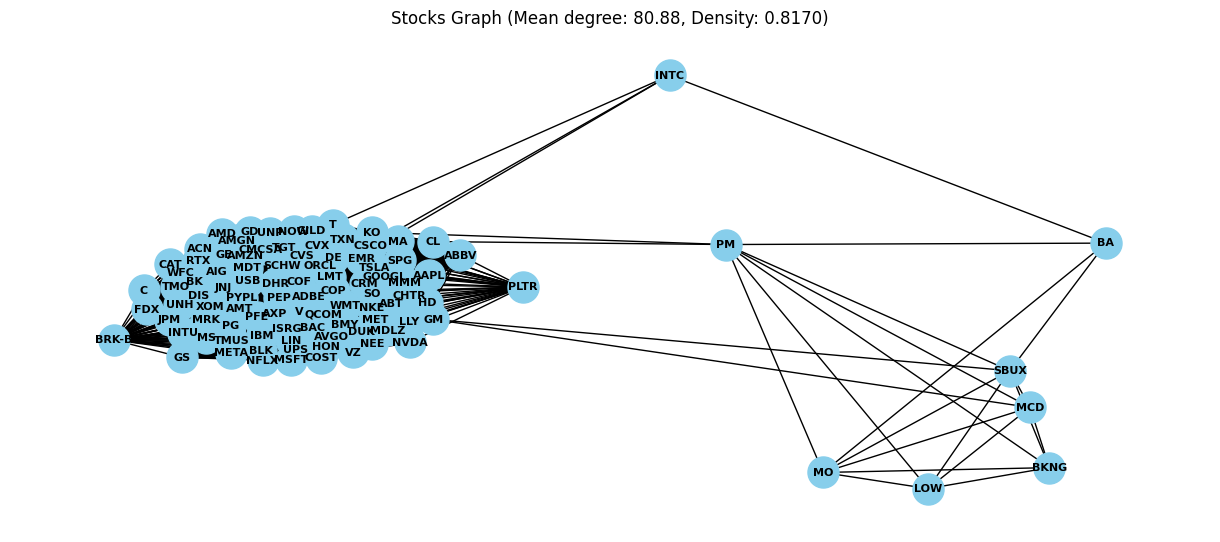

In [ ]:
corr_threshold, sector_bonus = .7, .05

share_sector = pd.get_dummies(stocks[["Sector"]]).transpose().corr().to_numpy().astype(int) - np.eye(len(stocks), dtype=int)
# abs because GCNConv only accepts positive weights
adj = abs(fundamentals_corr_np) + share_sector * sector_bonus
adj = adj * (abs(adj) > corr_threshold)
adj = adj / adj.max()

graph = nx.from_numpy_array(adj)
graph = nx.relabel_nodes(graph, dict(enumerate(stocks.index)))

plt.figure(figsize=(12, 5))
nx.draw(graph, with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', font_color='black', pos=nx.spring_layout(graph, k=.5))
plt.title(f'Stocks Graph (Mean degree: {np.mean([degree for node, degree in graph.degree]):.2f}, Density: {nx.density(graph):.4f})')
plt.show()

In [ ]:
np.save('/content/drive/MyDrive/Financial GNN/data/stocks.csv', adj)